In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
train_ds = torchvision.datasets.MNIST('.', train = True, transform = transforms.ToTensor(), download = True)
test_ds = torchvision.datasets.MNIST('.', train = False, transform = transforms.ToTensor(), download = False)


batch_size = 256
train_loader = torch.utils.data.DataLoader(train_ds, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size = batch_size, shuffle = False)

In [3]:
# model creation 
class ANN_v1(nn.Module):
  def __init__(self, criterion):
    super(ANN_v1, self).__init__()
    self.l1 = nn.Linear(784, 128)
    self.l2 = nn.ReLU()
    self.l3 = nn.Linear(128, 10)
    self.loss = criterion
  def forward(self, x):
    x = self.l1(x)
    x = self.l2(x)
    x = self.l3(x)
    return x

In [4]:
# declare criterion
criterion = nn.CrossEntropyLoss()

# initalize the model
ann_v1 = ANN_v1(criterion)

# specify an optimizer
optimizer = torch.optim.Adam(ann_v1.parameters(),lr = 0.001)


In [5]:
# pick the device to do calculations with a model passed to device.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
ann_v1.to(device)

cpu


ANN_v1(
  (l1): Linear(in_features=784, out_features=128, bias=True)
  (l2): ReLU()
  (l3): Linear(in_features=128, out_features=10, bias=True)
  (loss): CrossEntropyLoss()
)

In [6]:
# define train and prediction functions
import time
def train(model, train_loader, test_loader, optimizer, epochs):
  """
  Apply batch gradient descent to the model with given data loader. 
  """
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)
  train_accuracies = np.zeros(epochs)
  test_accuracies = np.zeros(epochs)
    
  for i in range(epochs):
    t0 = time.time()

    tmp_train_losses = []
    tmp_train_accuracies = []
    tmp_test_losses = []
    tmp_test_accuracies = []
    

    # calculate the loss and do backprop with train data to train the model
    for inputs, targets in train_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      inputs = inputs.view(-1, 784)

      # forward pass
      outputs = ann_v1.forward(inputs)
      loss = ann_v1.loss(outputs, targets)
      tmp_train_losses.append(loss.item())
      
      # back propagation
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      # calculate accuracy
      acc = get_accuracy(model, inputs, targets)
      tmp_train_accuracies.append(acc)

    # calculate the loss for test dataset
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      inputs = inputs.view(-1, 784)
      # forward pass
      outputs = ann_v1.forward(inputs)
      loss = ann_v1.loss(outputs, targets)
      tmp_test_losses.append(loss.item())
      # calculate accuracy
      acc = get_accuracy(model, inputs, targets)
      tmp_test_accuracies.append(acc)


    avg_tr_loss = np.mean(tmp_train_losses)
    avg_te_loss = np.mean(tmp_test_losses)
    avg_tr_acc = np.mean(tmp_train_accuracies)
    avg_te_acc = np.mean(tmp_test_accuracies)

    train_losses[i] = avg_tr_loss
    test_losses[i] = avg_te_loss
    train_accuracies[i] = avg_tr_acc
    test_accuracies[i] = avg_te_acc


    t1 = time.time()
    print("-"*50)
    print(f"Epochs {i+1}/{epochs} \n took {t1-t0:.4f}s \n avg_losses per batch: train: {avg_tr_loss:.4f} | test: {avg_te_loss:.4f} \n avg_accs per batch: train: {avg_tr_acc:.4f} | test: {avg_te_acc:.4f}")
    print("-"*50)

  return train_losses, train_accuracies, test_losses, test_accuracies

def get_accuracy(model, inputs, targets):
  # model outputs logits. So we need to convert them into label-based predictions. We can achieve this by simply getting the "maximum" value
  # of logit column since softmax is also increases if given input increases. 
  with torch.no_grad():
    _ , preds = torch.max(model(inputs), 1)
    accuracy = ((preds == targets).sum().item())/(targets.shape[0])
    return accuracy

def predict(model, data_loader):
  n_total = 0.
  n_correct = 0.
  with torch.no_grad():
    for inputs, targets in data_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      inputs = inputs.view(-1, 784)
      # make predictions
      _, preds = torch.max(model(inputs), 1)
      
      n_correct += (preds == targets).sum().item()
      n_total += targets.shape[0]

  return n_correct/n_total

In [7]:
train_loss, train_acc, test_loss, test_acc = train(ann_v1, train_loader, test_loader, optimizer, 10)

--------------------------------------------------
Epochs 1/10 
 took 5.8226s 
 avg_losses per batch: train: 0.5238 | test: 0.2700 
 avg_accs per batch: train: 0.8757 | test: 0.9248
--------------------------------------------------
--------------------------------------------------
Epochs 2/10 
 took 5.8126s 
 avg_losses per batch: train: 0.2408 | test: 0.1976 
 avg_accs per batch: train: 0.9334 | test: 0.9435
--------------------------------------------------
--------------------------------------------------
Epochs 3/10 
 took 5.8440s 
 avg_losses per batch: train: 0.1849 | test: 0.1633 
 avg_accs per batch: train: 0.9494 | test: 0.9530
--------------------------------------------------
--------------------------------------------------
Epochs 4/10 
 took 5.8445s 
 avg_losses per batch: train: 0.1497 | test: 0.1448 
 avg_accs per batch: train: 0.9590 | test: 0.9588
--------------------------------------------------
--------------------------------------------------
Epochs 5/10 
 too

In [8]:
x = list(range(1, 11))
fig = go.Figure()

fig.add_trace(go.Scatter(x = x, y = train_loss, mode = 'lines+markers', name = 'avg_train_loss'))
fig.add_trace(go.Scatter(x = x, y = test_loss, mode = 'lines+markers', name = 'avg_test_loss'))
fig.show()

fig.data = [] # remove the traces above

fig.add_trace(go.Scatter(x = x, y = train_acc, mode = 'lines+markers', name = 'avg_train_acc'))
fig.add_trace(go.Scatter(x = x, y = test_acc, mode = 'lines+markers', name = 'avg_test_acc'))
fig.show()

In [9]:
# make prediction with test data and get the accuracy
print("Make prediction with test data")
predict(ann_v1,test_loader)

Make prediction with test data


0.9736

In [10]:
# Plot confusion matrix (code snippet)
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[ 969    0    2    1    1    1    3    1    1    1]
 [   0 1122    4    0    0    1    3    1    4    0]
 [   5    2 1003    3    2    1    4    6    4    2]
 [   0    0    3  984    0    8    0    8    4    3]
 [   2    0    2    0  960    1    4    3    2    8]
 [   3    0    0    8    0  869    5    2    4    1]
 [   8    3    2    0    5    6  933    0    1    0]
 [   1    2   11    3    0    0    0 1003    1    7]
 [   7    0    3   16    6    5    9    6  917    5]
 [   3    3    1    8    9    3    2    4    0  976]]


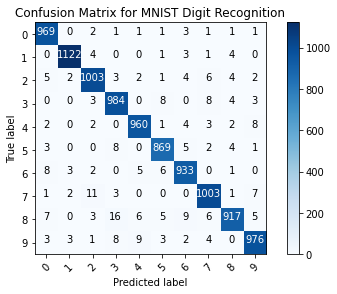

In [11]:
x_test = test_ds.data.numpy()
y_test = test_ds.targets.numpy()
p_test = np.array([])
for inputs, targets in test_loader:
  inputs = inputs.to(device)
  inputs = inputs.view(-1, 784)
  outputs = ann_v1(inputs)
  _, preds = torch.max(outputs, 1) # this returns maximum value and argmax but I only need argmax since it represents the same label for image.

  # concatenate preds with p_test
  # I use .cpu() to copy predictions to the CPU. Since model calculated it on GPU, I need to get it back to CPU in order to make something with it. 
  # Because we're doing our calculations (operations) mainly on CPU.
  p_test = np.concatenate((p_test, preds.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)), title = 'Confusion Matrix for MNIST Digit Recognition')

# of misclassified images:  264
2.64% of the images are misclassified.


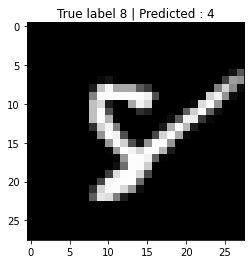

In [12]:
misclassified_idx = np.where(p_test != y_test)[0]
print('# of misclassified images: ',len(misclassified_idx))
print(f'{(len(misclassified_idx) / y_test.shape[0]) * 100 }% of the images are misclassified.')
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i], cmap = 'gray')
plt.title("True label %s | Predicted : %s" % (y_test[i], int(p_test[i])));